## Mach No. Vs. Polarization Skewness
- Same input model as wavy_test.ipynb
- For varying Mach No. what does polarization distribution look like? 
- Quantifies the skewness of the polarization distribution

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

def wavy_field_depol_test(M_A, Bz_true, amplitude_range, g_size, plotting=False):
    """
    ISM toy polarization model with LOS turbulence parameterized
    by Alfvénic Mach number M_A.
    """

    # =========================
    # REGIME CLASSIFICATION
    # =========================
    if M_A < 0.5:
        regime = "sub-Alfvénic"
        sigma_phi = M_A
    elif 0.5 <= M_A <= 1.0:
        regime = "trans-Alfvénic"
        sigma_phi = M_A
    else:
        regime = "super-Alfvénic"
        # Saturate angular dispersion (randomized field limit)
        # sigma_phi = np.pi / 2
        sigma_phi = M_A
        regime = "Super-Alfvénic regime: angular dispersion saturated; DCF assumptions invalid."

    print(f"Operating regime: {regime} (M_A = {M_A:.2f})")

    # =========================
    # PARAMETERS
    # =========================
    I0 = 1.0
    frequency = 1.0
    amplitude = np.linspace(amplitude_range[0], amplitude_range[1], g_size)

    Bx0, By0 = 1.0, 1.0
    corr_r = 0.9   # LOS correlation coefficient

    # =========================
    # GRID
    # =========================
    x = np.linspace(-np.pi, np.pi, g_size)
    y = np.linspace(-np.pi, np.pi, g_size)
    z = np.linspace(-np.pi, np.pi, g_size)
    X, Y, Z = np.meshgrid(x, y, z, indexing="xy")

    Bx = np.zeros_like(X)
    By = np.zeros_like(Y)
    Bz = np.zeros_like(Z)

    # =========================
    # LARGE-SCALE POS FIELD
    # =========================
    for iz in range(g_size):
        theta0 = amplitude[iz] * np.cos(frequency * X[:, :, iz])
        Bx[:, :, iz] = Bx0 * np.cos(theta0)
        By[:, :, iz] = By0 * np.sin(theta0)
        Bz[:, :, iz] = Bz_true

    # =========================
    # LOS TURBULENCE (AR(1))
    # =========================
    delta_theta = np.zeros((g_size, g_size, g_size))

    for ix in range(g_size):
        for iy in range(g_size):
            val = np.random.normal(scale=sigma_phi)
            for iz in range(g_size):
                delta_theta[ix, iy, iz] = val
                val = corr_r * val + np.random.normal(
                    scale=sigma_phi * np.sqrt(1 - corr_r**2)
                )

    # =========================
    # APPLY TURBULENT ROTATION
    # =========================
    Bx_rot = Bx * np.cos(delta_theta) - By * np.sin(delta_theta)
    By_rot = Bx * np.sin(delta_theta) + By * np.cos(delta_theta)

    Bx, By = Bx_rot, By_rot

    # =========================
    # OPTIONAL FIELD PLOTTING
    # =========================
    if plotting:
        fig, ax = plt.subplots(1, g_size, figsize=(18, 2))
        for iz in range(g_size):
            ax[iz].quiver(
                X[:, :, iz], Y[:, :, iz],
                Bx[:, :, iz], By[:, :, iz],
                pivot="middle",
                scale=2,
                scale_units="xy",
                headlength=0,
                headaxislength=0
            )
            ax[iz].set_title(f"z={iz}")
        plt.tight_layout()
        plt.show()

    # =========================
    # STOKES FROM FIELD
    # =========================
    Bperp2 = Bx**2 + By**2
    Btot2 = Bperp2 + Bz**2 + 1e-12

    cos2g = Bperp2 / Btot2
    q = (By**2 - Bx**2) / Btot2
    u = (2 * Bx * By) / Btot2

    Q3 = I0 * q
    U3 = I0 * u

    # =========================
    # LOS INTEGRATION
    # =========================
    Q_obs = Q3.sum(axis=2)
    U_obs = U3.sum(axis=2)
    I_obs = I0 * g_size

    P_obs = np.sqrt(Q_obs**2 + U_obs**2) / I_obs
    phi_obs = 0.5 * np.arctan2(U_obs, Q_obs)
    cos2g_LOS = cos2g.mean(axis=2)

    return P_obs, phi_obs, cos2g_LOS


Operating regime: sub-Alfvénic (M_A = 0.00)


/Users/sophiakressy/miniconda3/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Users/sophiakressy/miniconda3/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Operating regime: sub-Alfvénic (M_A = 0.25)
Operating regime: trans-Alfvénic (M_A = 0.50)
Operating regime: trans-Alfvénic (M_A = 0.75)
Operating regime: trans-Alfvénic (M_A = 1.00)
Operating regime: Super-Alfvénic regime: angular dispersion saturated; DCF assumptions invalid. (M_A = 3.00)


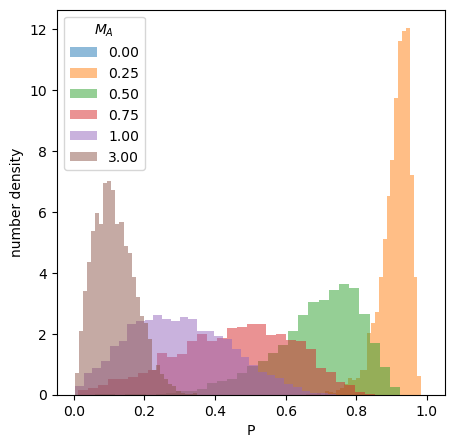

In [11]:
mach_vals = [0,0.25,0.5,0.75,1,3]#np.linspace(0,2,4)

plt.figure(figsize=(5,5))

for imach in mach_vals:
    P, PHI, C = wavy_field_depol_test(M_A = imach, Bz_true = 0, amplitude_range = [1,1], 
                                      g_size = 64, plotting = False)
    plt.hist(P.flatten(), bins=30, alpha=0.5, label=f"{imach:.2f}", density=True)
plt.xlabel("P")
plt.ylabel('number density')
plt.legend(title=r'$M_A$')

Operating regime: sub-Alfvénic (M_A = 0.20)
Operating regime: sub-Alfvénic (M_A = 0.30)
Operating regime: sub-Alfvénic (M_A = 0.40)
Operating regime: trans-Alfvénic (M_A = 0.50)
Operating regime: trans-Alfvénic (M_A = 0.75)
Operating regime: trans-Alfvénic (M_A = 1.00)
Operating regime: Super-Alfvénic regime: angular dispersion saturated; DCF assumptions invalid. (M_A = 1.50)
Operating regime: Super-Alfvénic regime: angular dispersion saturated; DCF assumptions invalid. (M_A = 2.00)
Operating regime: Super-Alfvénic regime: angular dispersion saturated; DCF assumptions invalid. (M_A = 3.00)


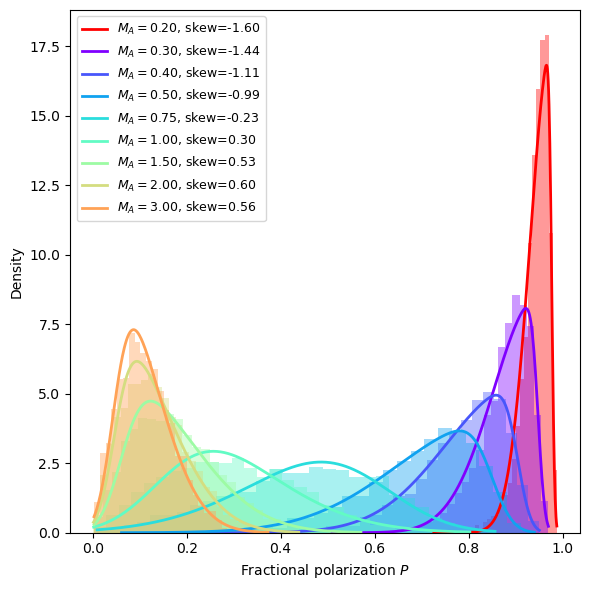

In [12]:
from scipy.stats import skew, skewnorm

plt.figure(figsize=(6, 6))
mach_vals = [0.2,0.3, 0.4, 0.5,0.75,1,1.5,2,3]
color = plt.cm.rainbow(np.linspace(0,1,len(mach_vals)+1))

for imach in mach_vals:

    # simulate
    P, PHI, C = wavy_field_depol_test(M_A=imach,Bz_true=0,amplitude_range=[1, 1],g_size=64,plotting=False)

    # flatten & clip to >0
    Pflat = P.flatten()
    Pflat = Pflat[Pflat > 0]

    # --- compute raw skewness ---
    skew_val = skew(Pflat, bias=False)

    # --- fit skewnormal distribution ---
    # skewnorm.fit returns (a, loc, scale)
    a, loc, scale = skewnorm.fit(Pflat)

    # build PDF for plotting
    x = np.linspace(Pflat.min(), Pflat.max(), 300)
    pdf_skew = skewnorm.pdf(x, a, loc=loc, scale=scale)

    # --- histogram ---
    plt.hist(Pflat, bins=30, density=True, alpha=0.4, color = color[mach_vals.index(imach)-1])

    # --- overlay skewnormal fit ---
    plt.plot(x, pdf_skew, lw=2, label=rf"$M_A={imach:.2f}$, skew={skew_val:.2f}", color=color[mach_vals.index(imach)-1])

plt.xlabel("Fractional polarization $P$")
plt.ylabel("Density")
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()


Operating regime: sub-Alfvénic (M_A = 0.00)
Operating regime: sub-Alfvénic (M_A = 0.02)


/var/folders/q3/hykz569d1r1c51lc9dq_8cb00000gn/T/ipykernel_22726/3296627184.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skews.append(skew(P.flatten(), bias=False))


Operating regime: sub-Alfvénic (M_A = 0.04)
Operating regime: sub-Alfvénic (M_A = 0.06)
Operating regime: sub-Alfvénic (M_A = 0.08)
Operating regime: sub-Alfvénic (M_A = 0.10)
Operating regime: sub-Alfvénic (M_A = 0.12)
Operating regime: sub-Alfvénic (M_A = 0.14)
Operating regime: sub-Alfvénic (M_A = 0.16)
Operating regime: sub-Alfvénic (M_A = 0.18)
Operating regime: sub-Alfvénic (M_A = 0.20)
Operating regime: sub-Alfvénic (M_A = 0.22)
Operating regime: sub-Alfvénic (M_A = 0.24)
Operating regime: sub-Alfvénic (M_A = 0.26)
Operating regime: sub-Alfvénic (M_A = 0.28)
Operating regime: sub-Alfvénic (M_A = 0.30)
Operating regime: sub-Alfvénic (M_A = 0.32)
Operating regime: sub-Alfvénic (M_A = 0.34)
Operating regime: sub-Alfvénic (M_A = 0.36)
Operating regime: sub-Alfvénic (M_A = 0.38)
Operating regime: sub-Alfvénic (M_A = 0.40)
Operating regime: sub-Alfvénic (M_A = 0.42)
Operating regime: sub-Alfvénic (M_A = 0.44)
Operating regime: sub-Alfvénic (M_A = 0.46)
Operating regime: sub-Alfvénic (

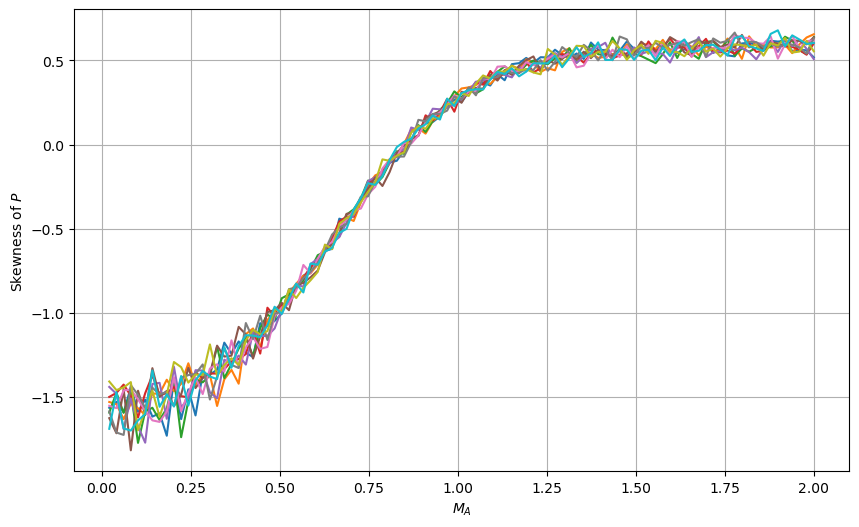

In [13]:
plt.figure(figsize=(10, 6))
n = 10
for i in range(n):
    skews = []
    mach_vals = np.linspace(0,2.0,100)
    # mach_vals = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.5,4,4.5,5]
    for imach in mach_vals:
        P, _, _ = wavy_field_depol_test(M_A=imach,Bz_true=0,amplitude_range=[1,1],g_size=64,plotting=False)
        skews.append(skew(P.flatten(), bias=False))

    plt.plot(mach_vals, skews, linestyle='-')
    
plt.xlabel(r"$M_A$")
plt.ylabel("Skewness of $P$")
plt.grid(True)
plt.show()

##### Visual check - polarization map

In [ ]:
# ngrains = 10
# P, PHI, C = wavy_field_depol_test(M_A = 1, Bz_true = 0, amplitude_range = [1,1], 
#                                       g_size = ngrains, plotting = False)
# # POS magnetic field components inferred from observables
# Bx_obs = P * np.sin(PHI)
# By_obs = P * np.cos(PHI)

# ix = np.arange(ngrains)
# iy = np.arange(ngrains)
# XX, YY = np.meshgrid(ix, iy, indexing='xy')

# plt.figure(figsize=(6, 6))

# plt.quiver(XX, YY, Bx_obs, By_obs, angles='xy', scale_units='xy', scale=1, pivot='middle',
#     headwidth=0, headlength=0, headaxislength=0, linewidth=1, color='blue', alpha=0.7)

# plt.title("Observed POS magnetic field (XY plane)")
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.axis('equal')
# plt.tight_layout()
# plt.show()

##### visual check - plot observables

In [ ]:
# # ===============================
# # PLOTS
# # ===============================
# P, PHI, C = wavy_field_depol_test(M_A = 1, Bz_true = 0, amplitude_range = [1,1], 
#                                       g_size = 64, plotting = False)

# fig, axs = plt.subplots(1, 4, figsize=(18, 4))
# L=0.5
# extent = [-L, L, -L, L]

# im0 = axs[0].imshow(P.T, origin="lower", extent=extent, cmap="viridis")
# plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
# axs[0].set_title("P_obs")

# im1 = axs[1].imshow(PHI.T, origin="lower", extent=extent, cmap="twilight")
# plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
# axs[1].set_title("phi_obs")

# im2 = axs[2].imshow(C, origin="lower",
#                     extent=extent, cmap="inferno")
# plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
# axs[2].set_title("cos²γ")

# axs[3].scatter(C.flatten(), P.flatten(), s=20, label='cos2g_LOS')
# axs[3].set_xlabel("cos²γ")
# axs[3].set_ylabel("P")
# # axs[3].set_xlim(0.9,1.1)
# plt.tight_layout()
# plt.show()
